In [1]:
"""
Purpose: To Run the proofreading of neurons in the 
test set and measure the precision and recall of the new rules

Segments to look out for that had no axon
864691135012395766 # one of the split segments files not there (split index = 1)
864691135865584005 #soma soma merger
864691136451113215 #it was an inhibitory neuron (part of split)

"""

'\nPurpose: To Run the proofreading of neurons in the \ntest set and measure the precision and recall of the new rules\n\nSegments to look out for that had no axon\n864691135012395766 # one of the split segments files not there (split index = 1)\n864691135865584005 #soma soma merger\n864691136451113215 #it was an inhibitory neuron (part of split)\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-05-26 14:10:16,348 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 14:10:16,351 - settings - Setting database.user to celiib
INFO - 2021-05-26 14:10:16,352 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 14:10:16,356 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-05-26 14:10:16,357 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 14:10:16,371 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-05-26 14:10:16,847 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 14:10:16,851 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 14:10:16,852 - settings - Setting database.user to celiib
INFO - 2021-05-26 14:10:16,853 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 14:10:16,854 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 14:10:16,854 - settings - Setting database.user to celiib
INFO - 2021-05-26 14:10:16,855 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 14:10:16,858 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 14:10:17,381 - settings - Setting enable_python_native_blobs to True


In [4]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-05-26 14:10:25,583 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 14:10:25,584 - settings - Setting database.user to celiib
INFO - 2021-05-26 14:10:25,585 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 14:10:25,590 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 14:10:26,203 - settings - Setting enable_python_native_blobs to True


In [5]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru
import proofreading_utils as pru
import time
import system_utils as su

# Getting the Results of the Validation

In [12]:
pre_source = (minnie.AutoProofreadValidationSegmentMap4() & 
    (dj.U("old_segment_id") & minnie.DecompositionAxon.proj(old_segment_id="segment_id")))

key_source = (pre_source - 
              du.current_validation_segment_id_exclude.proj(old_segment_id="segment_id")
              #& dict(old_segment_id=864691135373402824)
             )
key_source

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,old_segment_id the segment id in the proofread version--,finished_dendrite whether axon was finished cleaning,finished_axon whether axon was finished cleaning,extension_type,n_somas,n_soma_mergers,n_glia,large_splits,notes
88.00,189149,864691135855890478,0.08,864691135585319036,True,True,full,1,0,0,0,
88.00,223037,864691136227167569,0.08,864691135538120050,True,True,full,2,0,0,0,
88.00,225498,864691135753932237,0.08,864691135564655959,True,True,full,1,0,0,0,
88.00,230236,864691135609687047,0.08,864691135748568361,True,True,full,1,0,0,0,
88.00,236197,864691136903144370,0.08,864691135758569550,True,True,full,2,0,2,0,
88.00,258307,864691135293126156,0.08,864691136194042326,True,True,full,1,0,0,0,
88.00,262773,864691136023889209,0.08,864691135233108569,True,True,full,1,0,0,0,
88.00,264870,864691136951664863,0.08,864691135740225387,True,True,full,1,0,0,0,
88.00,269247,864691135584074360,0.08,864691136105498585,True,True,full,1,0,0,0,
88.00,269380,864691135974639471,0.08,864691134988386682,True,True,full,1,0,0,0,


In [13]:
#(schema.jobs & "table_name = '__auto_proofread_validation_score4'").delete()

In [6]:
minnie,_ = du.configure_minnie_vm()
validation_dfs = minnie.AutoProofreadValidationScore4().fetch("validation_df")
validation_dfs = [vu.load_df_val_from_numpy(k) for k in validation_dfs]
validation_dfs

INFO - 2021-05-26 14:12:35,342 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-05-26 14:12:35,344 - settings - Setting database.user to celiib
INFO - 2021-05-26 14:12:35,345 - settings - Setting database.password to newceliipass
INFO - 2021-05-26 14:12:35,349 - settings - Setting enable_python_native_blobs to True
INFO - 2021-05-26 14:12:40,943 - settings - Setting enable_python_native_blobs to True


[     synapse_id synapse_type auto_valid synapse_x synapse_y synapse_z  \
 0      76963424       presyn       True    521800    532392    972400   
 1      76963829       presyn       True    523416    531720    972240   
 2      76964110       presyn       True    524512    532600    972680   
 3      78899369       presyn       True    534080    501888    975520   
 4      78899421       presyn       True    534352    501976    975760   
 ...         ...          ...        ...       ...       ...       ...   
 5503  117704562      postsyn      False    612136    502816   1005040   
 5504  117704639      postsyn      False    612600    502936   1005600   
 5505  117704984      postsyn      False    614240    498816   1006840   
 5506  121682236      postsyn      False    622088    517176   1012840   
 5507  137292646      postsyn      False    659096    515676    926400   
 
      manual_valid category      old_segment_id      new_segment_id  \
 0            True       TP  8646911355

In [7]:
import pandas_utils as pu
total_validation_df = pu.concat(validation_dfs)
total_validation_df

,synapse_id,synapse_type,auto_valid,synapse_x,synapse_y,synapse_z,manual_valid,category,old_segment_id,new_segment_id,euclidean_distance_to_nuclei
0,76963424,presyn,True,521800,532392,972400,True,TP,864691135585319036,864691135855890478,76638.6
1,76963829,presyn,True,523416,531720,972240,True,TP,864691135585319036,864691135855890478,75006.3
2,76964110,presyn,True,524512,532600,972680,True,TP,864691135585319036,864691135855890478,74918.2
3,78899369,presyn,True,534080,501888,975520,False,FP,864691135585319036,864691135855890478,49643.6
4,78899421,presyn,True,534352,501976,975760,False,FP,864691135585319036,864691135855890478,49517.3
...,...,...,...,...,...,...,...,...,...,...,...
5357,481632172,postsyn,False,1473224,695480,749840,True,FN,864691136056340440,864691135724393131,68025.8
5358,481632213,postsyn,False,1473840,695184,749120,True,FN,864691136056340440,864691135724393131,68850
5359,481632269,postsyn,False,1473888,696528,747480,True,FN,864691136056340440,864691135724393131,69491.1
5360,481632479,postsyn,False,1475160,697832,747160,True,FN,864691136056340440,864691135724393131,70829.3


Segment Id = 864691134988385914
Postsyn counts:
TP:519700
TN:113822
FP:7123
FN:11807
Presyn counts:
TP:2563
TN:26564
FP:768
FN:850


WARNING - 2021-05-26 14:20:42,371 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNING - 2021-05-26 14:20:42,402 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNING - 2021-05-26 14:20:42,409 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


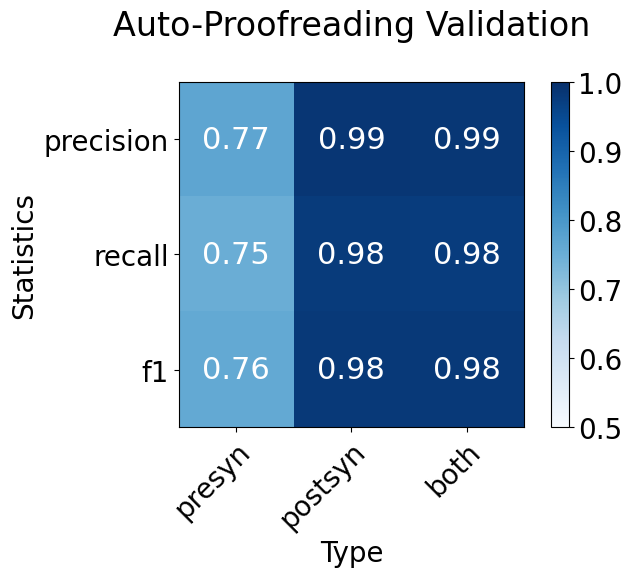

In [14]:
vu.synapse_validation_df_to_score_plot(total_validation_df)

# Look at the Neurons That did Poorly

In [17]:
minnie.AutoProofreadValidationScore4() & 

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,189149,864691135855890478,0.08,0,=BLOB=,378.9958361551676,=BLOB=,=BLOB=,7,158,13,0,0.35,1.0,0.5185185185185185,5281,7,39,3,0.9926691729323308,0.9994322482967449,0.9960392304790645,274.43
88.00,223037,864691136227167569,0.08,0,=BLOB=,63.375728490237755,=BLOB=,=BLOB=,0,450,0,0,nan,nan,nan,1,3410,3859,0,0.00025906735751295336,1.0,0.000518000518000518,312.6
88.00,225498,864691135753932237,0.08,0,=BLOB=,185.8554437449504,=BLOB=,=BLOB=,6,77,0,5,1.0,0.5454545454545454,0.7058823529411764,1124,0,0,9,1.0,0.9920564872021183,0.9960124058484714,135.29
88.00,230236,864691135609687047,0.08,0,=BLOB=,1573.6491914056435,=BLOB=,=BLOB=,34,549,12,16,0.7391304347826086,0.68,0.7083333333333334,1961,22,1,1,0.9994903160040775,0.9994903160040775,0.9994903160040775,410.46
88.00,236197,864691136903144370,0.08,0,=BLOB=,40.753447012345966,=BLOB=,=BLOB=,0,975,0,5,nan,0.0,nan,2750,2329,7,48,0.9974610083424011,0.9828448892065761,0.99009900990099,610.46
88.00,258307,864691135293126156,0.08,0,=BLOB=,1079.2637317809197,=BLOB=,=BLOB=,44,340,12,26,0.7857142857142857,0.6285714285714286,0.6984126984126985,2984,7,25,19,0.9916915918909937,0.9936729936729937,0.9926813040585496,287.43
88.00,262773,864691136023889209,0.08,0,=BLOB=,191.70683649485437,=BLOB=,=BLOB=,9,48,2,0,0.8181818181818182,1.0,0.9,724,0,2,10,0.9972451790633609,0.9863760217983651,0.9917808219178083,91.14
88.00,264870,864691136951664863,0.08,0,=BLOB=,1021.2379299332463,=BLOB=,=BLOB=,31,422,2,1,0.9393939393939394,0.96875,0.9538461538461539,2008,25,4,33,0.9980119284294234,0.9838314551690348,0.9908709597828769,253.88
88.00,269247,864691135584074360,0.08,0,=BLOB=,2323.8059162243367,=BLOB=,=BLOB=,237,36,4,7,0.983402489626556,0.9713114754098361,0.9773195876288661,806,0,7,65,0.991389913899139,0.9253731343283582,0.9572446555819477,445.96
88.00,269380,864691135974639471,0.08,0,=BLOB=,640.9539351441155,=BLOB=,=BLOB=,27,237,24,11,0.5294117647058824,0.7105263157894737,0.6067415730337078,1863,4,8,3,0.9957242116515232,0.9983922829581994,0.9970564624029972,211.19


In [22]:
bad_seg_ids = (minnie.AutoProofreadValidationSegmentMap4() * (minnie.AutoProofreadValidationScore4() & "pre_precision < 0.5" & "pre_fp > 15")).fetch("segment_id")
bad_seg_ids

array([864691135446675028, 864691135367058169, 864691135181923074,
       864691136329122794, 864691136903228594, 864691135571017453])

In [26]:
segment_id = bad_seg_ids[4]
curr_table = (minnie.AutoProofreadValidationScore4() & dict(segment_id=segment_id))
curr_table

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds)
88.00,560530,864691136903228594,0.08,0,=BLOB=,2160.357939835724,=BLOB=,=BLOB=,21,682,96,3,0.1794871794871795,0.875,0.2978723404255319,2130,4115,22,40,0.9897769516728625,0.9815668202764977,0.985654789449329,630.29


In [28]:
segment_id = bad_seg_ids[4]
curr_table = (minnie.AutoProofreadValidationScore4() & dict(segment_id=segment_id))
decomp_path,validation_df = curr_table.fetch1("decomposition","validation_df")
neuron_obj = du.filepath_to_neuron_obj(decomp_path)

Decompressing Neuron in minimal output mode...please wait


In [29]:
nviz.visualize_neuron(neuron_obj,
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [33]:
return_validation_df_revised = vu.load_df_val_from_numpy(validation_df)
filt_neuron = neuron_obj
vu.plot_validation_synapses(filt_neuron.segment_id,
                            validation_df = return_validation_df_revised,
                             synapse_dict = None,
                             synapses_type_to_plot = None,
                             synapses_type_to_not_plot = None,
                             verbose=False,
                             synapse_type = "presyn",
                             TP_color="yellow",
                            TN_color="aqua",
                            FP_color="black",
                            FN_color="orange",
                             synapse_scatter_size = 0.05,
                             
                             #for plotting the actual mesh parts to go along
                             
                             neuron_obj = filt_neuron,
                             plot_only_axon_skeleton = True,
                             error_mesh_color = "red",
                             valid_mesh_color = "green",
                             valid_skeleton_color = "black",
                             mesh_alpha = 0.3,)

Using the mesh from the neuron object


TP:yellow
TN:aqua
FP:black
FN:orange


In [53]:
import networkx_utils as xu
xu.upstream_node(neuron_obj[0].concept_network_directional,70)

86

In [54]:
neuron_obj[0][86].skeletal_length

1815.3245970886237

In [51]:
nviz.plot_limb_branch_dict(neuron_obj,
                          {'L0': np.array([ 70])})


 Working on visualization type: mesh


In [87]:
neuron_obj[0][70].width_new

{'median_mesh_center': 121.107717022825,
 'no_spine_median_mesh_center': 121.107717022825,
 'no_bouton_median': 121.107717022825}

In [ ]:
axon_comparison_distance = 1000,

In [89]:
import neuron_searching as ns
result_limb_branch = ns.query_neuron(neuron_obj,
    functions_list=["parent_angle","upstream_skeletal_length","skeletal_length","axon_width"],
    query="(parent_angle>110) and (skeletal_length>5000) and (upstream_skeletal_length>1000) and (axon_width>105)",
        function_kwargs=dict(comparison_distance=1000),
    return_dataframe=False,
    limbs_to_process=[neuron_obj.axon_limb_name])

print(f"result_limb_branch = {result_limb_branch}")
nviz.plot_limb_branch_dict(neuron_obj,
                           result_limb_branch)

result_limb_branch = {'L0': array([70])}

 Working on visualization type: mesh


In [82]:
nviz.plot_limb_branch_dict(neuron_obj,
                          {"L0":[17,23]})


 Working on visualization type: mesh


In [80]:
xu.downstream_nodes(curr_limb.concept_network_directional,
                   17)

array([14, 23])

In [76]:
import neuron_utils as nru
curr_limb = neuron_obj[0]
parent_angle = nru.find_parent_child_skeleton_angle(curr_limb,
                                            23,
                                                    comparison_distance=1000,
                                            plot_extracted_skeletons=True)
parent_angle

comparison_distance = 1000
Parent (17):red, child (23):blue


63.38

In [64]:
xu.upstream_node(curr_limb.concept_network_directional,23)

17

In [66]:
bs = [17,23]
c = ["red","blue"]
nviz.plot_objects(meshes=[curr_limb[k].mesh for k in bs],
                 meshes_colors=c,
                 skeletons =[curr_limb[k].skeleton for k in bs],
                 skeletons_colors=c)

In [65]:
nviz.plot_branches_with_spines(neuron_obj[0][17])

No spines to plot
width = {'median_mesh_center': 65.63172438624116, 'no_spine_median_mesh_center': 65.63172438624116, 'no_bouton_median': 65.63172438624116}, 
n_spines = 0,
 spine_density = 0.0
 spine_volume_density = 0
skeleton_length (in microns) = 2.060270913207183
area = 1.5219801101741797


In [61]:
nviz.plot_branches_with_spines(neuron_obj[0][23])

No spines to plot
width = {'median_mesh_center': 57.22539465536521, 'no_spine_median_mesh_center': 57.22539465536521, 'no_bouton_median': 55.70202379720557}, 
n_spines = 0,
 spine_density = 0.0
 spine_volume_density = 0
skeleton_length (in microns) = 87.632672345696
area = 48.8246109925849


In [35]:
nviz.plot_limb_branch_dict(neuron_obj,
                           result_limb_branch)

'L0'

# Trying Out the New Error Function

In [90]:
curr_table = (minnie.AutoProofreadValidationScore4() & dict(segment_id=segment_id))
curr_table*minnie.AutoProofreadValidationSegmentMap4()

ver materialization version,nucleus_id nucleus id,segment_id the segment id in the proofread version,old_ver materialization version,split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,decomposition saved neuron object with high fidelity axon,axon_length axon length of the filtered neuron,validation_df,validation_df_ext,pre_tp,pre_tn,pre_fp,pre_fn,pre_precision,pre_recall,pre_f1,post_tp,post_tn,post_fp,post_fn,post_precision,post_recall,post_f1,run_time the amount of time to run (seconds),old_segment_id the segment id in the proofread version--,finished_dendrite whether axon was finished cleaning,finished_axon whether axon was finished cleaning,extension_type,n_somas,n_soma_mergers,n_glia,large_splits,notes
88.00,560530,864691136903228594,0.08,0,=BLOB=,2160.357939835724,=BLOB=,=BLOB=,21,682,96,3,0.1794871794871795,0.875,0.2978723404255319,2130,4115,22,40,0.9897769516728625,0.9815668202764977,0.985654789449329,630.29,864691135462735678,True,True,full,3,0,0,0,maybe small glia merged with soma inside


In [93]:
decomp_path = (minnie.DecompositionAxon() & dict(segment_id=864691135462735678,
                                  split_index = 0
                                 )).fetch1("decomposition")
pre_filt_neuron = du.filepath_to_neuron_obj(decomp_path)

Decompressing Neuron in minimal output mode...please wait


In [95]:
pre_filt_neuron

In [96]:
nviz.visualize_neuron(pre_filt_neuron,
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [102]:
(filt_neuron,
             return_synapse_df_revised,
             return_synapse_df_errors,
            return_validation_df_revised,
            return_validation_df_extension) =  vu.filtered_neuron_score(neuron_obj = pre_filt_neuron,   
                                filter_list = [pru.exc_double_back_and_width_change_filter],
                                plot_limb_branch_filter_with_disconnect_effect = True,
                                verbose = True,
                                plot_score=False,
                                nucleus_id = 560530,
                                return_synapse_df_errors=True,
                                return_validation_df_extension = True,                                        
                                split_index=0)


--- Working on filter 0:
function = double_back_and_width_change
function __name__ = filter_away_large_double_back_or_width_changes
function arguments = {'perform_double_back_errors': True, 'skip_double_back_errors_for_axon': False, 'width_jump_threshold': 250, 'running_width_jump_method': True, 'double_back_axon_like_threshold': 130, 'axon_comparison_distance': 1500, 'double_back_threshold': 120, 'allow_axon_double_back_angle_with_top': None, 'allow_axon_double_back_angle_with_top_width_min': 120, 'skeletal_length_to_skip': 4000, 'comparison_distance': 3000, 'perform_width_errors': True, 'perform_axon_width_errors': False}


limb_branch_dict_to_cancel = {'L0': [312, 376, 377, 364, 361, 98, 290, 338, 339, 308, 310, 16, 49, 1, 259, 261, 262, 263, 265, 267, 273, 275, 276, 277, 278, 280, 352, 286, 351, 298, 299, 177, 179, 191, 192, 323, 206, 208, 209, 215, 345, 247, 219, 349, 222, 223, 224, 225, 226, 227, 228, 229, 358, 231, 232, 233, 357, 363, 230, 237, 235, 236, 368, 360, 242, 234, 244




 ---- Total time for applying filter: 188.73477125167847 -----

--- Finished Part 1: Filtering Neuron -----
Apply the presyn non_error
For presyn: # valid synapses = 254, # error synapses  = 548, # error presyns = 57
For postsyn: # valid synapses = 2173, # error synapses  = 4134, # error presyns = 0
presyn_error = [395010913 398599464 399086883 399172893 399405080 400384788 400384824
 401052946 401453548 401962292 401962879 401997104 404969000 405188428
 405274162 405389872 405664028 407197244 407197378 407197540 408028562
 408028927 408100088 409032033 409070583 409099029 411077218 411263744
 411263800 411264666 411265222 411265534 411265855 411265882 413365817
 413444441 413444940 413444989 413445432 413445472 414642824 414860863
 414961832 420075192 421766929 429094191 431431567 431431627 433894201
 446495861 446497027 447553898 452319255 458996294 460784631 460817672
 460818353]

--- Finished Part 2: Filtering Synapses -----
Synapsse Results:
Total Number of Synapses = 7109
n_va

# Trying on the ALREADY Proofread Neuron

In [103]:
segment_id = bad_seg_ids[4]
curr_table = (minnie.AutoProofreadValidationScore4() & dict(segment_id=segment_id))
decomp_path,validation_df = curr_table.fetch1("decomposition","validation_df")
neuron_obj = du.filepath_to_neuron_obj(decomp_path)

Decompressing Neuron in minimal output mode...please wait


In [ ]:
neuron_obj[0][70]

In [ ]:
(filt_neuron,
             return_synapse_df_revised,
             return_synapse_df_errors,
            return_validation_df_revised,
            return_validation_df_extension) =  vu.filtered_neuron_score(neuron_obj = pre_filt_neuron,   
                                filter_list = [pru.exc_double_back_and_width_change_filter],
                                plot_limb_branch_filter_with_disconnect_effect = True,
                                verbose = True,
                                plot_score=False,
                                nucleus_id = 560530,
                                return_synapse_df_errors=True,
                                return_validation_df_extension = True,                                        
                                split_index=0)